In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy import misc, ndimage

from PIL import Image
import PIL
import imageio



## 1. Understanding image super-resolution

In [2]:
def modcrop(image, scale=3):
    """
    To scale down and up the original image, first thing to do is to have no remainder while scaling operation.

    We need to find modulo of height (and width) and scale factor.
    Then, subtract the modulo from height (and width) of original image size.
    There would be no remainder even after scaling operation.
    """
    #print(type(image))
    if len(image.shape) == 3:
        #print(image.shape)
        h, w, _ = image.shape
        h = h - np.mod(h, scale)
        w = w - np.mod(w, scale)
        image = image[0:h, 0:w, :]
    else:
        #print(image.shape)
        h, w = image.shape
        h = h - np.mod(h, scale)
        w = w - np.mod(w, scale)
        image = image[0:h, 0:w]
    return image

In [3]:
def preprocess(path, scale=3):
    """
    Preprocess single image file
      (1) Read original image as YCbCr format (and grayscale as default)
      (2) Normalize
      (3) Apply image file with bicubic interpolation
    Args:
      path: file path of desired file
      input_: image applied bicubic interpolation (low-resolution)
      label_: image with original resolution (high-resolution)
    """
    image = imread(path, 'L')
    img = np.array(image, copy=False)
    label_ = modcrop(img, scale)
    #print(type(label_))

    #label_ = np.asarray(scale_img(image, scale))
   
    # Must be normalized
    label_ = label_ / 255.
     
    size = label_.shape
    
    new_im1 = Image.fromarray(label_)
    #print(np.max(label_))
    #new_im1.show()
    new_im2 = new_im1.resize((int(size[0]*(1./scale)), int(size[1]*(1./scale))), resample=PIL.Image.BICUBIC)   
    new_im3 = new_im2.resize((int(np.array(new_im2).shape[0]*(scale/1.)), int(np.array(new_im2).shape[1]*(scale/1.))), resample=PIL.Image.BICUBIC)
    
    input_ = np.array(new_im3, copy=False)
    #print(input_.shape)
    #input_ = scipy.ndimage.interpolation.zoom(label_, (1./scale), prefilter=False)
    #input_ = scipy.ndimage.interpolation.zoom(input_, (scale/1.), prefilter=False)
    print(np.max(input_))

    return input_, label_



In [4]:
def imread(path, mode):
    """
    Read image from the giving path.
    """
    return Image.open(path).convert(mode)

In [5]:
# read image:
image = imread("./image/butterfly_GT.bmp", "L"); 

In [6]:
#type(image)

In [7]:
# show image size: 
np_image = np.array(image, copy=False)
print(np_image.shape)
#print(image.shape)

(256, 256)


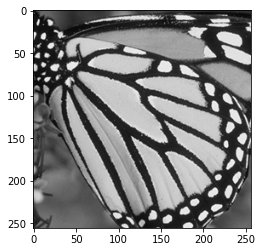

In [8]:
# show image
%matplotlib inline
s = plt.imshow(np.asarray(image), cmap="gray")

In [9]:
def scale_img1(image, scale): 
    size = np.array(image, copy=True).shape
    return image.resize((int(size[0]*scale), int(size[1]*scale)), resample=PIL.Image.BICUBIC)

In [10]:
#scale up 3x:
image_rescaled_up = scale_img1(image, 3)

In [11]:
# show image size: 
np_image = np.array(image_rescaled_up, copy=False)
print(np_image.shape)

(768, 768)


In [12]:
#scale down 3x:
image_rescaled_down = scale_img1(image, 1/3)

In [13]:
# show image size: 
np_image = np.array(image_rescaled_down, copy=False)
print(np_image.shape)
#print(image.shape)

(85, 85)


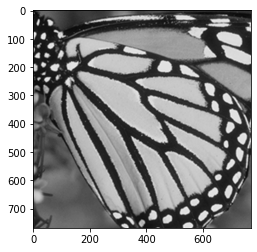

In [14]:
%matplotlib inline
u = plt.imshow(np.asarray(image_rescaled_up), cmap="gray")

#plt.show()

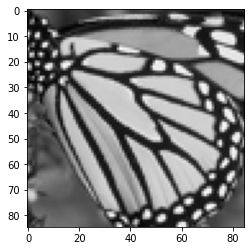

In [15]:
d = plt.imshow(np.asarray(image_rescaled_down), cmap="gray")


In [16]:
#img = Image.open('./image/butterfly_GT.bmp').convert('LA')
#img.save('greyscaletest.png')

## 2. Understanding deep learning by convolutional neural network

In [17]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=5, padding=2)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = self.conv3(out)
        return out

In [18]:
# Load the pre-trained model file
model = SRCNN()
model.load_state_dict(torch.load('./model/model.pth'))
model.eval()

SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)

In [19]:
print("Model's state_dict:")
print(model.state_dict().keys())
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias'])
conv1.weight 	 torch.Size([64, 1, 9, 9])
conv1.bias 	 torch.Size([64])
conv2.weight 	 torch.Size([32, 64, 1, 1])
conv2.bias 	 torch.Size([32])
conv3.weight 	 torch.Size([1, 32, 5, 5])
conv3.bias 	 torch.Size([1])


In [20]:
# show the weights of the first convolutional layer
print(model.state_dict()['conv1.weight'])

tensor([[[[ 0.0543,  0.1042, -0.0486,  ..., -0.0165,  0.0816,  0.0057],
          [ 0.0574, -0.0135, -0.0037,  ..., -0.0127,  0.0219,  0.0616],
          [-0.0807, -0.0719,  0.0278,  ..., -0.0233, -0.0164,  0.0834],
          ...,
          [ 0.0960, -0.0534,  0.0297,  ...,  0.0457,  0.0409, -0.0667],
          [ 0.0556,  0.0913,  0.0070,  ...,  0.0796, -0.1015, -0.0356],
          [ 0.0567,  0.1139,  0.1075,  ..., -0.0272, -0.1107, -0.1224]]],


        [[[ 0.1041,  0.0961, -0.0887,  ..., -0.0440,  0.0588, -0.0387],
          [ 0.0490,  0.0698,  0.1020,  ...,  0.0706,  0.0483, -0.0470],
          [-0.0523,  0.1193,  0.0952,  ...,  0.0235, -0.0636, -0.0577],
          ...,
          [ 0.0026,  0.0128,  0.0104,  ...,  0.0947,  0.1181,  0.0123],
          [-0.0921, -0.0414,  0.0864,  ..., -0.0933, -0.0864, -0.0016],
          [ 0.0634,  0.0669, -0.1012,  ..., -0.0355, -0.0213, -0.0092]]],


        [[[-0.1196, -0.1039, -0.0393,  ..., -0.0771,  0.0324,  0.1426],
          [-0.0330,  0.105

In [21]:
# show the value of the 1st filter 
print(model.state_dict()['conv1.weight'][0])


tensor([[[ 5.4323e-02,  1.0422e-01, -4.8600e-02, -7.6126e-02, -5.0001e-02,
           7.5404e-03, -1.6507e-02,  8.1600e-02,  5.7272e-03],
         [ 5.7435e-02, -1.3518e-02, -3.7220e-03, -1.0587e-01, -7.8043e-02,
          -6.1384e-02, -1.2669e-02,  2.1881e-02,  6.1611e-02],
         [-8.0736e-02, -7.1947e-02,  2.7774e-02,  1.0592e-01,  1.8931e-02,
           1.0604e-01, -2.3304e-02, -1.6359e-02,  8.3361e-02],
         [-1.1829e-01, -1.0814e-01, -2.4699e-02,  2.9971e-02,  2.3308e-01,
           3.3854e-02, -1.3157e-02, -9.5279e-02, -1.2888e-01],
         [-6.1250e-02,  6.8379e-02,  6.2341e-02,  1.3684e-01,  1.6767e-01,
           8.0704e-02,  8.0051e-02, -1.0970e-01, -1.0261e-01],
         [-4.3840e-02,  6.3762e-02,  7.7752e-02, -1.0020e-02,  7.8726e-02,
           1.3858e-01,  1.3216e-01,  3.5202e-02, -4.7966e-03],
         [ 9.5997e-02, -5.3369e-02,  2.9721e-02, -9.7120e-02, -8.0721e-02,
          -6.0766e-02,  4.5733e-02,  4.0888e-02, -6.6666e-02],
         [ 5.5552e-02,  9.1251e-02

In [22]:
# show the bias of the 10th filter
print(model.state_dict()['conv1.bias'][9])


tensor(-0.0059)


In [23]:
# show the value of the 5th filter 
print(model.state_dict()['conv2.weight'][4])


tensor([[[-0.1321]],

        [[ 0.1568]],

        [[-0.0709]],

        [[ 0.0966]],

        [[-0.1001]],

        [[ 0.0460]],

        [[ 0.1027]],

        [[ 0.1326]],

        [[ 0.0582]],

        [[ 0.1265]],

        [[ 0.1125]],

        [[-0.0349]],

        [[ 0.0593]],

        [[ 0.0418]],

        [[-0.1154]],

        [[-0.0481]],

        [[ 0.0181]],

        [[ 0.5133]],

        [[-0.1194]],

        [[-0.0020]],

        [[ 0.0465]],

        [[ 0.0949]],

        [[-0.0011]],

        [[-0.1103]],

        [[ 0.0912]],

        [[ 0.2364]],

        [[-0.3405]],

        [[ 0.1157]],

        [[-0.3255]],

        [[ 0.0554]],

        [[ 0.0208]],

        [[ 0.1063]],

        [[ 0.1765]],

        [[ 0.1644]],

        [[ 0.1111]],

        [[ 0.1161]],

        [[-0.0742]],

        [[ 0.0584]],

        [[ 0.1666]],

        [[ 0.0112]],

        [[ 0.1956]],

        [[-0.1409]],

        [[ 0.5043]],

        [[-0.0041]],

        [[ 0.0569]],

        [[

In [24]:
# show the bias of the 6th filter
print(model.state_dict()['conv2.bias'][5])


tensor(0.0980)


In [25]:
# show the weight of the 1st filter
print(model.state_dict()['conv3.weight'][0])


tensor([[[-7.8392e-03,  1.8380e-02, -4.2910e-03,  4.9119e-02, -1.1819e-02],
         [ 4.9276e-03, -4.0848e-02,  3.1710e-02, -4.4035e-03,  2.6088e-02],
         [ 7.7921e-03, -1.7259e-02, -1.6308e-02, -1.7886e-02,  2.0402e-02],
         [ 4.1349e-02,  3.8067e-02, -1.6652e-02, -1.9819e-02, -1.9812e-02],
         [ 8.9309e-03,  1.4456e-02, -5.8866e-03, -3.1343e-02,  2.1219e-03]],

        [[ 8.1215e-06, -2.7240e-02, -8.5476e-03, -3.6805e-04, -3.3223e-02],
         [ 5.9710e-03,  1.0744e-02, -2.2513e-03, -3.8128e-03,  1.9573e-03],
         [ 1.0084e-02, -1.5887e-02, -2.2154e-03,  2.1386e-02, -9.2471e-03],
         [ 1.0385e-03, -3.1633e-02, -2.5824e-02, -2.3028e-03, -1.1081e-02],
         [ 3.5357e-02, -6.5919e-03, -2.8458e-02,  3.1191e-02, -2.1767e-02]],

        [[ 3.2316e-02, -4.6434e-03,  5.5312e-03, -3.5767e-02,  3.2152e-02],
         [ 3.8669e-03, -1.9297e-02, -2.6522e-02,  4.7022e-03, -3.1685e-02],
         [ 2.8219e-02,  2.1340e-02,  3.9184e-02,  3.3854e-02, -2.0186e-02],
        

In [26]:
# show the bias of the 1st filter
print(model.state_dict()['conv3.bias'][0])

tensor(-0.0100)


In [27]:
# perform 2-d convolution filtering on a 2-d matrix (defraded image) with a given filter : 
conv = torch.nn.Sequential(nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1))#, nn.ReLU())
fil = torch.tensor(([[1, 0, 1], [1, 0, 1], [1, 0, 1]]), dtype=float) # filter
for idx, param in enumerate(conv.parameters()):
    if idx == 0: 
        param = torch.nn.Parameter(fil)
    if idx == 1: 
        param = torch.nn.Parameter(torch.ones((1))) # bais set at 1 no effect 

0.99584746


<ipython-input-28-b38379e0a00b>:4: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  input_ = torch.from_numpy(input_)


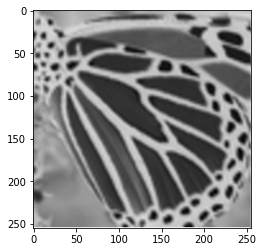

In [28]:
Bi_Cubic_image, HR_image = preprocess('./image/butterfly_GT.bmp')
# transform the input to 4-D tensor
input_ = np.expand_dims(np.expand_dims(Bi_Cubic_image, axis=0), axis=0)
input_ = torch.from_numpy(input_)
input_ = input_.float()

out_conv = conv(input_)
out_conv = out_conv.detach().numpy()
plt.imshow(out_conv[0,0, :,:], cmap='gray')



## 3. Image super-resolution using deep convolutional network

In [29]:
# read the test image

Bi_Cubic_image, HR_image = preprocess('./image/butterfly_GT.bmp')
# transform the input to 4-D tensor
input_ = np.expand_dims(np.expand_dims(Bi_Cubic_image, axis=0), axis=0)
input_ = torch.from_numpy(input_)
input_ = input_.float()

0.99584746


In [30]:
with torch.no_grad():
    output_ = model(input_)

In [31]:
image_output = output_.numpy()

print(image_output.shape)
print(type(image_output))
print(np.max(image_output))
print(np.min(image_output))

(1, 1, 255, 255)
<class 'numpy.ndarray'>
1.26892
-0.06013173


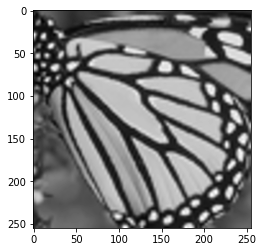

In [32]:
plt.imshow(Bi_Cubic_image, cmap="gray")
plt.show()
Image.fromarray( (Bi_Cubic_image * 255).astype('uint8'), mode='L').save("./output images/LR_image.png") 
#print(type(LR_image))
#print(LR_image)


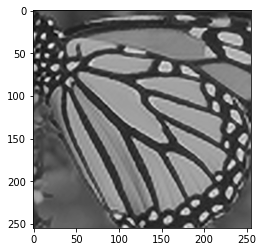

In [33]:
plt.imshow(image_output[0,0,:,:],cmap="gray")

data_img = np.squeeze(np.clip(image_output[0,0,:,:]*255, 0.0, 255.0)).astype(np.uint8)
data_img1 = Image.fromarray(data_img, mode='L')
data_img1.save("./output images/SR_image.jpg")



In [36]:
#np.max((image_output[0,0,:,:]*255))


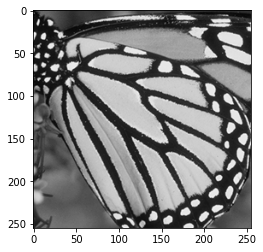

In [37]:
plt.imshow(HR_image, cmap="gray")
plt.show()
Image.fromarray( (HR_image * 255).astype('uint8'), mode='L').save("./output images/HR_image.jpg") 

In [39]:
from skimage import data, io, filters
import numpy, math
##------ Add your code here: save the blurred and SR images and compute the psnr
# hints: use the 'scipy.misc.imsave()'  and ' skimage.measure.compare_psnr()' - did not work

def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    
    return 20. * math.log10(1 / math.sqrt(mse))

In [40]:
print("\nHR-BI PSNR {:0.2f}\n".format(psnr(Bi_Cubic_image, HR_image)))
print("\nHR-SRCNN {:0.2f}\n".format(psnr(np.squeeze(image_output), HR_image)))
#print(psnr(LR_image, HR_image))
#print(psnr(np.squeeze(image_output), HR_image))


HR-BI PSNR 22.73


HR-SRCNN 23.65



In [ ]:
"""
def calc_psnr(img1, img2):
    m = torch.mean( (torch.from_numpy(img1) - torch.from_numpy(img2) ) ** 2)
    return 10. * torch.log10(1 ** 2/ m )
"""

In [ ]:
#print(calc_psnr(LR_image, HR_image))

In [ ]:
#print(calc_psnr(np.squeeze(image_output), HR_image))

In [ ]:
"""
def imread1(path, is_grayscale=True):
    
    Read image from the giving path.
    Default value is gray-scale, and image is read by YCbCr format as the paper.
    
    if is_grayscale:
        return imageio.imread(path, as_gray=True, pilmode='YCbCr' ).astype(np.float32)
    else:
        return imageio.imread(path, pilmode='YCbCr').astype(np.float32)
"""

In [ ]:
"""
# define a function for peak signal-to-noise ratio (PSNR)

from skimage.measure import compare_ssim as ssim
def psnr1(target, ref):
         
    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

# define function for mean squared error (MSE)
def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

# define function that combines all three image quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr1(np.squeeze(image_output), HR_image))
    scores.append(mse(np.squeeze(image_output), HR_image))
    scores.append(ssim(np.squeeze(image_output), HR_image, multichannel =True))
    
    return scores
"""


In [ ]:
#print(compare_images(np.squeeze(image_output), HR_image))